In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd

df = pd.read_csv("공모전_data.csv")


📌 Target: 관측_습도


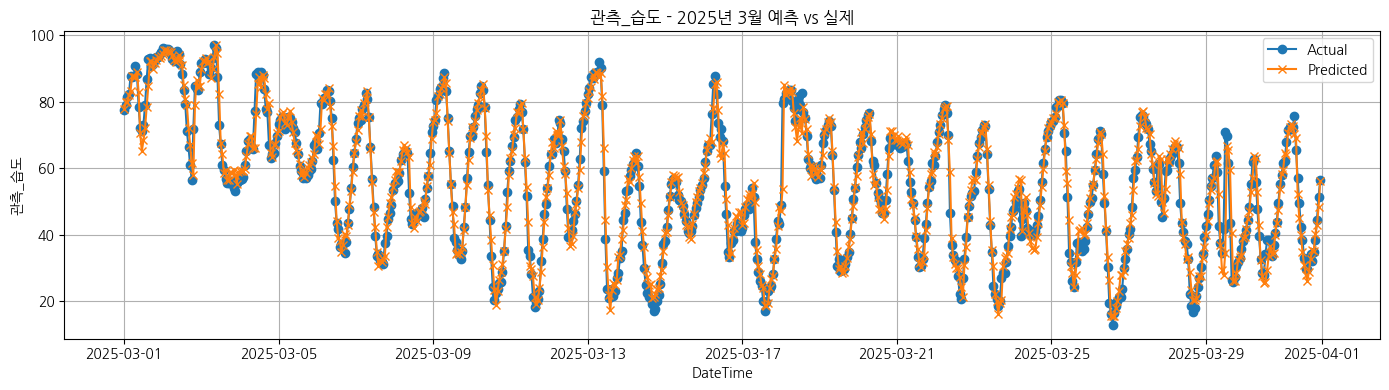


📌 Target: 관측_대기압


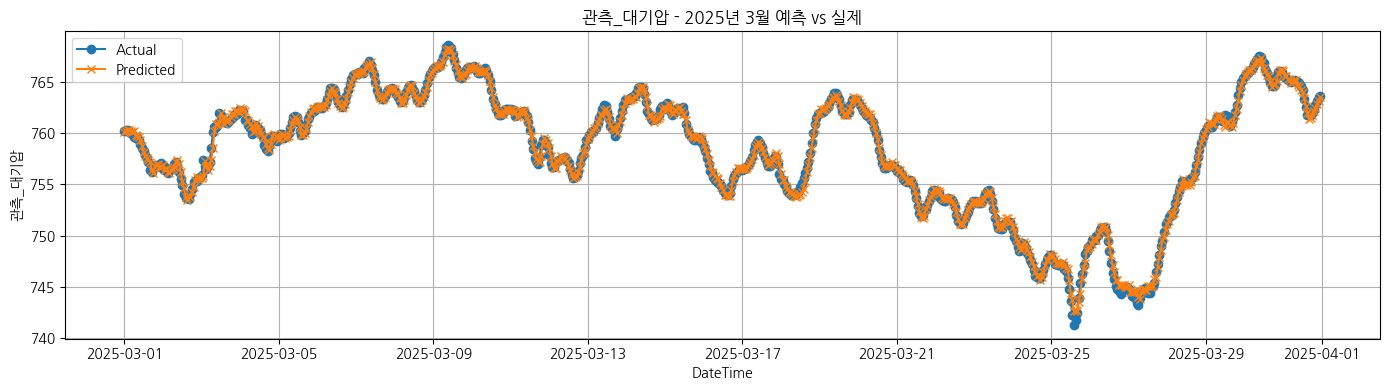


📌 Target: 관측_기온


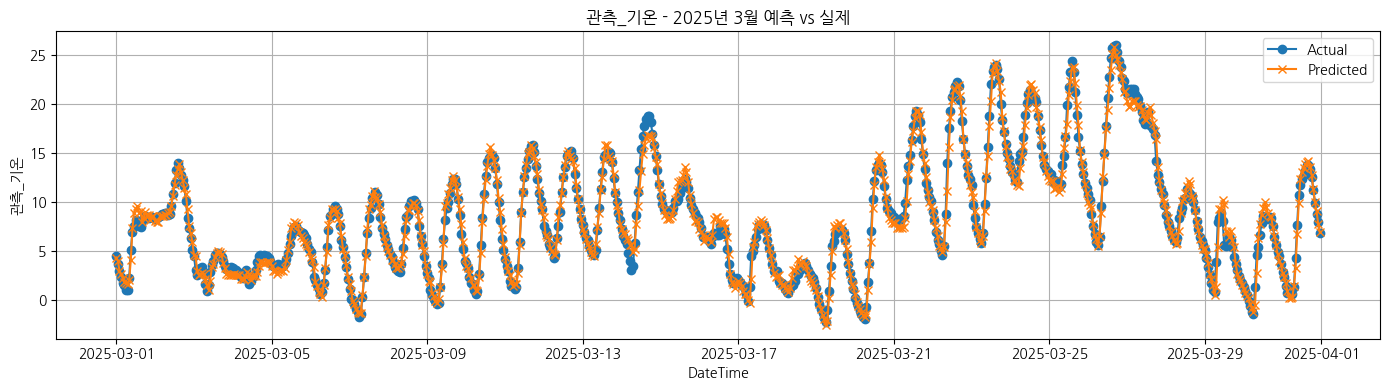


✅ 최종 평가 지표 (sAError 기준)
sRMSE  = 1.5374
sMAE   = 1.0399
sAError = 1.2887


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# 데이터 로드 및 전처리
df = pd.read_csv("공모전_data.csv")
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df.set_index('기상관측일시', inplace=True)

# 시간 정보 feature 추가
df['월'] = df.index.month
df['일'] = df.index.day
df['시'] = df.index.hour

# 타깃 및 가중치
target_cols = ['관측_습도', '관측_대기압', '관측_기온']
weights = {'관측_습도': 0.3, '관측_대기압': 0.2, '관측_기온': 0.5}

# Lag feature 생성
for col in target_cols:
    for lag in range(1, 25):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 결측 제거
df = df.dropna()

# Train/Test 분할
test_df = df[(df.index.year == 2025) & (df.index.month == 3)]
train_df = df[df.index < test_df.index.min()]

# 예측값 + 시간 feature
extra_features = ['예측_기온', '예측_습도', '예측_절대습도', '예측_일사량', '예측_대기압', '월', '일', '시']

# 결과 저장
results = {}
sRMSE = 0
sMAE = 0

# 타깃별 모델 학습 및 평가
for col in target_cols:
    print(f"\n📌 Target: {col}")
    w = weights[col]

    # feature 목록 = 예측값 + 시간정보 + lag 피처
    feature_cols = extra_features + [f'{col}_lag{lag}' for lag in range(1, 25)]

    X_train = train_df[feature_cols]
    y_train = train_df[col]
    X_test = test_df[feature_cols]
    y_test = test_df[col]

    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    sRMSE += w * rmse
    sMAE += w * mae

    results[col] = {
        'weight': w,
        'rmse': rmse,
        'mae': mae,
        'w_rmse': w * rmse,
        'w_mae': w * mae
    }

    # 시각화
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
    plt.title(f'{col} - 2025년 3월 예측 vs 실제')
    plt.xlabel('DateTime')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 종합 성능 출력
sAError = (sRMSE + sMAE) / 2
print("\n✅ 최종 평가 지표 (sAError 기준)")
print(f"sRMSE  = {sRMSE:.4f}")
print(f"sMAE   = {sMAE:.4f}")
print(f"sAError = {sAError:.4f}")


📌 Target: 관측_습도


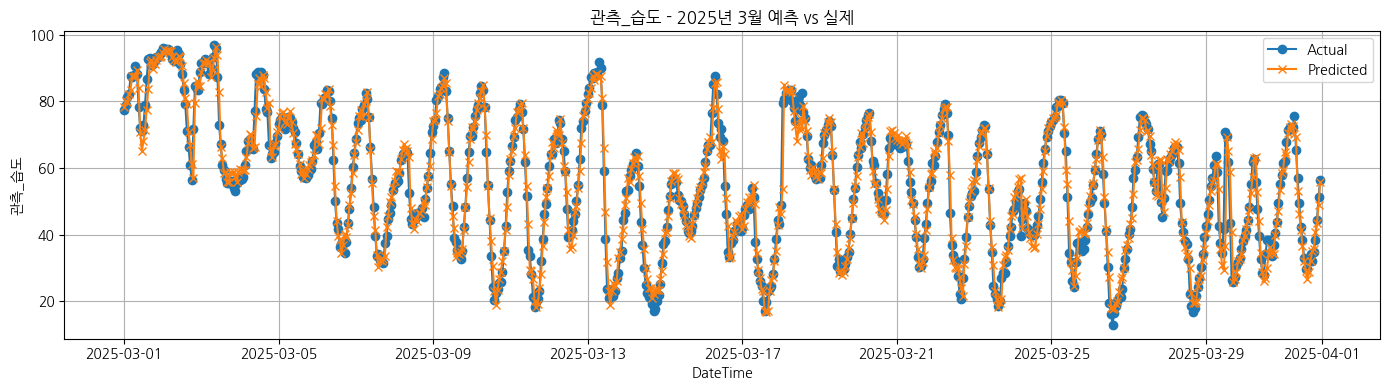


📌 Target: 관측_대기압


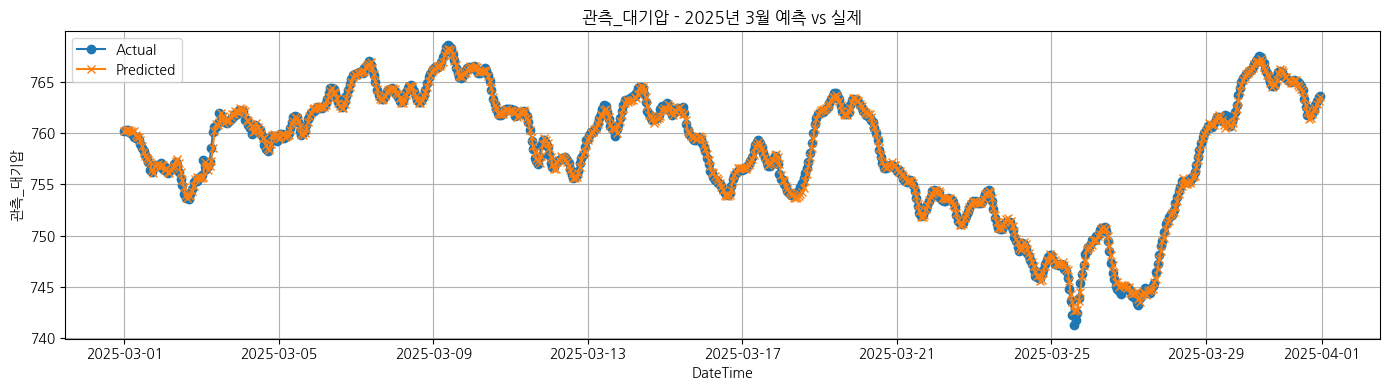


📌 Target: 관측_기온


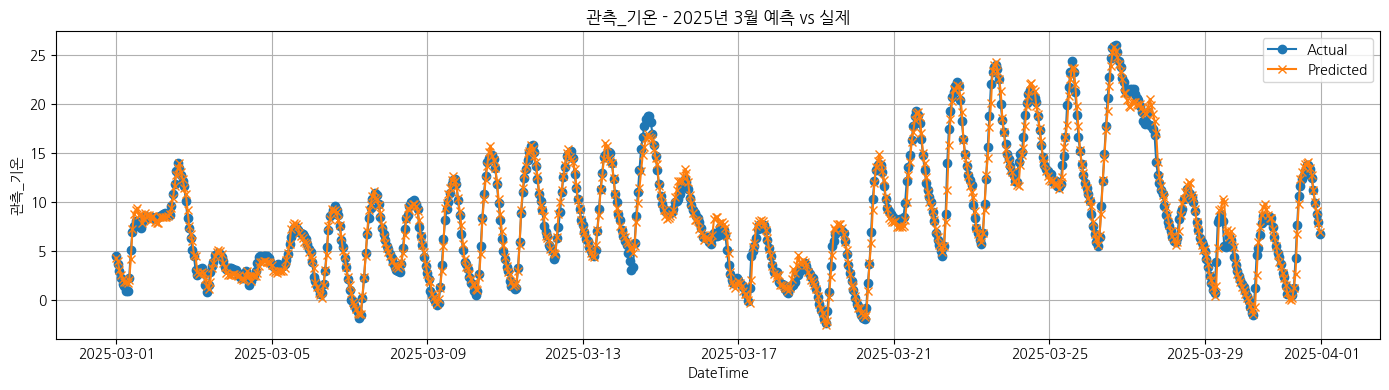


✅ 최종 평가 지표 (sAError 기준)
sRMSE  = 1.5336
sMAE   = 1.0370
sAError = 1.2853

📊 변수별 평가 지표

📌 관측_습도
  - RMSE     : 3.7128
  - MAE      : 2.4556
  - W * RMSE : 1.1138
  - W * MAE  : 0.7367

📌 관측_대기압
  - RMSE     : 0.3200
  - MAE      : 0.2352
  - W * RMSE : 0.0640
  - W * MAE  : 0.0470

📌 관측_기온
  - RMSE     : 0.7116
  - MAE      : 0.5065
  - W * RMSE : 0.3558
  - W * MAE  : 0.2533


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# 데이터 로드 및 전처리
df = pd.read_csv("공모전_data.csv")
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df.set_index('기상관측일시', inplace=True)

# 시간 정보 feature 추가
df['월'] = df.index.month
df['일'] = df.index.day
df['시'] = df.index.hour

# 타깃 및 가중치
target_cols = ['관측_습도', '관측_대기압', '관측_기온']
weights = {'관측_습도': 0.3, '관측_대기압': 0.2, '관측_기온': 0.5}

# Lag feature 생성
for col in target_cols:
    for lag in range(1, 25):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 결측 제거
df = df.dropna()

# Train/Test 분할
test_df = df[(df.index.year == 2025) & (df.index.month == 3)]
train_df = df[df.index < test_df.index.min()]

# 예측값 + 시간 feature
extra_features = ['예측_기온', '예측_습도', '예측_절대습도', '예측_일사량', '예측_대기압', '월', '일', '시']

# 결과 저장
results = {}
models = {}   # ← 타깃별 모델 저장용 딕셔너리
sRMSE = 0
sMAE = 0

# 타깃별 모델 학습 및 평가
for col in target_cols:
    print(f"\n📌 Target: {col}")
    w = weights[col]

    lag_features = []
    for target in target_cols:
        lag_features += [f'{target}_lag{lag}' for lag in range(1, 25)]

    feature_cols = extra_features + lag_features

    X_train = train_df[feature_cols]
    y_train = train_df[col]
    X_test = test_df[feature_cols]
    y_test = test_df[col]

    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    # ✅ 모델 저장 (딕셔너리에)
    models[col] = model

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    sRMSE += w * rmse
    sMAE += w * mae

    results[col] = {
        'weight': w,
        'rmse': rmse,
        'mae': mae,
        'w_rmse': w * rmse,
        'w_mae': w * mae
    }

    # 시각화
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
    plt.title(f'{col} - 2025년 3월 예측 vs 실제')
    plt.xlabel('DateTime')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 종합 성능 출력
sAError = (sRMSE + sMAE) / 2
print("\n✅ 최종 평가 지표 (sAError 기준)")
print(f"sRMSE  = {sRMSE:.4f}")
print(f"sMAE   = {sMAE:.4f}")
print(f"sAError = {sAError:.4f}")

# 개별 변수별 평가 결과 출력
print("\n📊 변수별 평가 지표")
for col in target_cols:
    r = results[col]
    print(f"\n📌 {col}")
    print(f"  - RMSE     : {r['rmse']:.4f}")
    print(f"  - MAE      : {r['mae']:.4f}")
    print(f"  - W * RMSE : {r['w_rmse']:.4f}")
    print(f"  - W * MAE  : {r['w_mae']:.4f}")


In [ ]:
feature_cols

['예측_기온',
 '예측_습도',
 '예측_절대습도',
 '예측_일사량',
 '예측_대기압',
 '월',
 '일',
 '시',
 '관측_습도_lag1',
 '관측_습도_lag2',
 '관측_습도_lag3',
 '관측_습도_lag4',
 '관측_습도_lag5',
 '관측_습도_lag6',
 '관측_습도_lag7',
 '관측_습도_lag8',
 '관측_습도_lag9',
 '관측_습도_lag10',
 '관측_습도_lag11',
 '관측_습도_lag12',
 '관측_습도_lag13',
 '관측_습도_lag14',
 '관측_습도_lag15',
 '관측_습도_lag16',
 '관측_습도_lag17',
 '관측_습도_lag18',
 '관측_습도_lag19',
 '관측_습도_lag20',
 '관측_습도_lag21',
 '관측_습도_lag22',
 '관측_습도_lag23',
 '관측_습도_lag24',
 '관측_대기압_lag1',
 '관측_대기압_lag2',
 '관측_대기압_lag3',
 '관측_대기압_lag4',
 '관측_대기압_lag5',
 '관측_대기압_lag6',
 '관측_대기압_lag7',
 '관측_대기압_lag8',
 '관측_대기압_lag9',
 '관측_대기압_lag10',
 '관측_대기압_lag11',
 '관측_대기압_lag12',
 '관측_대기압_lag13',
 '관측_대기압_lag14',
 '관측_대기압_lag15',
 '관측_대기압_lag16',
 '관측_대기압_lag17',
 '관측_대기압_lag18',
 '관측_대기압_lag19',
 '관측_대기압_lag20',
 '관측_대기압_lag21',
 '관측_대기압_lag22',
 '관측_대기압_lag23',
 '관측_대기압_lag24',
 '관측_기온_lag1',
 '관측_기온_lag2',
 '관측_기온_lag3',
 '관측_기온_lag4',
 '관측_기온_lag5',
 '관측_기온_lag6',
 '관측_기온_lag7',
 '관측_기온_lag8',
 '관측_기온_lag9',
 '관측_기온_lag10',
 '관

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

# 타깃 컬럼 목록과 이미 학습된 모델 딕셔너리
target_cols = ['관측_습도', '관측_대기압', '관측_기온']
# models = {'관측_습도': model1, '관측_대기압': model2, '관측_기온': model3}  ← 이미 정의돼 있어야 함

# 원본 데이터 불러오기
df = pd.read_csv("공모전_data.csv")
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df.set_index('기상관측일시', inplace=True)

for col in target_cols:
    df.loc[(df.index.date == pd.to_datetime('2025-03-31').date()), col] = np.nan

# lag feature 생성 (학습 시와 동일하게)
for col in target_cols:
    for lag in range(1, 25):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 시작과 끝 시간 정의
start_time = pd.Timestamp('2025-03-31 00:00')
end_time = pd.Timestamp('2025-03-31 23:00')

# 슬라이싱해서 새로운 DataFrame 생성
subset_df = df.loc[start_time:end_time].copy()
subset_df

,관측_습도,관측_기온,관측_대기압,예측_일사량,예측_습도,예측_절대습도,예측_기온,예측_대기압,월,일,...,관측_기온_lag15,관측_기온_lag16,관측_기온_lag17,관측_기온_lag18,관측_기온_lag19,관측_기온_lag20,관측_기온_lag21,관측_기온_lag22,관측_기온_lag23,관측_기온_lag24
기상관측일시,,,,,,,,,,,,,,,,,,,,,
2025-03-31 00:00:00,NaN,NaN,NaN,0.000000,39.207001,0.002,-0.691999,759.216064,3,31,...,5.34,4.58,1.28,-1.51,-1.27,-0.71,-0.13,0.44,0.89,1.31
2025-03-31 01:00:00,NaN,NaN,NaN,0.000000,43.692001,0.003,-0.407000,758.845520,3,31,...,6.60,5.34,4.58,1.28,-1.51,-1.27,-0.71,-0.13,0.44,0.89
2025-03-31 02:00:00,NaN,NaN,NaN,0.000000,44.277000,0.003,-0.695999,758.627380,3,31,...,7.85,6.60,5.34,4.58,1.28,-1.51,-1.27,-0.71,-0.13,0.44
2025-03-31 03:00:00,NaN,NaN,NaN,0.000000,46.292999,0.003,-1.002001,758.398926,3,31,...,8.55,7.85,6.60,5.34,4.58,1.28,-1.51,-1.27,-0.71,-0.13
2025-03-31 04:00:00,NaN,NaN,NaN,0.000000,47.687000,0.003,-1.254000,758.298096,3,31,...,8.35,8.55,7.85,6.60,5.34,4.58,1.28,-1.51,-1.27,-0.71
2025-03-31 05:00:00,NaN,NaN,NaN,0.000000,49.853001,0.003,-1.516999,758.332947,3,31,...,8.31,8.35,8.55,7.85,6.60,5.34,4.58,1.28,-1.51,-1.27
2025-03-31 06:00:00,NaN,NaN,NaN,0.000000,49.202999,0.003,-1.725999,758.364136,3,31,...,8.22,8.31,8.35,8.55,7.85,6.60,5.34,4.58,1.28,-1.51
2025-03-31 07:00:00,NaN,NaN,NaN,78.492996,48.907001,0.003,1.180999,758.548950,3,31,...,8.45,8.22,8.31,8.35,8.55,7.85,6.60,5.34,4.58,1.28
2025-03-31 08:00:00,NaN,NaN,NaN,272.885010,42.224998,0.003,5.365000,758.618591,3,31,...,8.36,8.45,8.22,8.31,8.35,8.55,7.85,6.60,5.34,4.58


In [ ]:
# 예측 대상: subset_df
# 전제: subset_df의 인덱스는 시간(datetime), feature_cols 및 models, target_cols 정의 완료됨

def predict_one(models, row_df):
    X = row_df[feature_cols]
    preds = [models[col].predict(X)[0] for col in target_cols]
    return dict(zip(target_cols, preds))

# subset_df에 대해 시간 순서대로 예측 반복
for ts in subset_df.index:
    # 현재 row의 관측값이 NaN이면 예측 수행
    if subset_df.loc[ts, target_cols].isna().any():
        row_df = subset_df.loc[[ts]]  # DF 형태 유지
        preds = predict_one(models, row_df)

        # 예측값을 관측값에 채움
        for col in target_cols:
            subset_df.loc[ts, col] = preds[col]

        # 이후 시간의 lag feature에 이 예측값 반영
        for lag_hour in range(1, 25):  # lag1 ~ lag24
            future_ts = ts + pd.Timedelta(hours=lag_hour)
            if future_ts in subset_df.index:
                for col in target_cols:
                    subset_df.loc[future_ts, f"{col}_lag{lag_hour}"] = subset_df.loc[ts, col]
subset_df

,관측_습도,관측_기온,관측_대기압,예측_일사량,예측_습도,예측_절대습도,예측_기온,예측_대기압,월,일,...,관측_기온_lag15,관측_기온_lag16,관측_기온_lag17,관측_기온_lag18,관측_기온_lag19,관측_기온_lag20,관측_기온_lag21,관측_기온_lag22,관측_기온_lag23,관측_기온_lag24
기상관측일시,,,,,,,,,,,,,,,,,,,,,
2025-03-31 00:00:00,59.315880,2.726346,765.982849,0.000000,39.207001,0.002,-0.691999,759.216064,3,31,...,5.340000,4.580000,1.280000,-1.510000,-1.270000,-0.710000,-0.130000,0.440000,0.890000,1.31
2025-03-31 01:00:00,61.721767,1.877910,765.931152,0.000000,43.692001,0.003,-0.407000,758.845520,3,31,...,6.600000,5.340000,4.580000,1.280000,-1.510000,-1.270000,-0.710000,-0.130000,0.440000,0.89
2025-03-31 02:00:00,64.064651,1.225550,765.839478,0.000000,44.277000,0.003,-0.695999,758.627380,3,31,...,7.850000,6.600000,5.340000,4.580000,1.280000,-1.510000,-1.270000,-0.710000,-0.130000,0.44
2025-03-31 03:00:00,65.495926,0.588274,765.813843,0.000000,46.292999,0.003,-1.002001,758.398926,3,31,...,8.550000,7.850000,6.600000,5.340000,4.580000,1.280000,-1.510000,-1.270000,-0.710000,-0.13
2025-03-31 04:00:00,67.724030,0.139316,765.636230,0.000000,47.687000,0.003,-1.254000,758.298096,3,31,...,8.350000,8.550000,7.850000,6.600000,5.340000,4.580000,1.280000,-1.510000,-1.270000,-0.71
2025-03-31 05:00:00,69.022034,-0.282072,765.583130,0.000000,49.853001,0.003,-1.516999,758.332947,3,31,...,8.310000,8.350000,8.550000,7.850000,6.600000,5.340000,4.580000,1.280000,-1.510000,-1.27
2025-03-31 06:00:00,69.601379,-0.493031,765.562134,0.000000,49.202999,0.003,-1.725999,758.364136,3,31,...,8.220000,8.310000,8.350000,8.550000,7.850000,6.600000,5.340000,4.580000,1.280000,-1.51
2025-03-31 07:00:00,67.906296,0.495272,765.624451,78.492996,48.907001,0.003,1.180999,758.548950,3,31,...,8.450000,8.220000,8.310000,8.350000,8.550000,7.850000,6.600000,5.340000,4.580000,1.28
2025-03-31 08:00:00,62.104778,2.550480,765.453125,272.885010,42.224998,0.003,5.365000,758.618591,3,31,...,8.360000,8.450000,8.220000,8.310000,8.350000,8.550000,7.850000,6.600000,5.340000,4.58


In [ ]:
df = pd.read_csv("공모전_data.csv")
df['기상관측일시'] = pd.to_datetime(df['기상관측일시'])
df.set_index('기상관측일시', inplace=True)
actual = df.loc['2025-03-31']
actual_data = actual[['관측_습도', '관측_기온', '관측_대기압']]
subset_data = subset_df[['관측_습도', '관측_기온', '관측_대기압']]

In [ ]:
actual_data

,관측_습도,관측_기온,관측_대기압
기상관측일시,,,
2025-03-31 00:00:00,61.48,2.77,765.60910
2025-03-31 01:00:00,62.24,2.31,765.49436
2025-03-31 02:00:00,67.73,1.42,765.36447
2025-03-31 03:00:00,71.33,0.66,765.20855
2025-03-31 04:00:00,72.28,0.65,765.03071
2025-03-31 05:00:00,71.61,0.59,765.01209
2025-03-31 06:00:00,72.44,0.54,765.06335
2025-03-31 07:00:00,75.78,1.28,765.22093
2025-03-31 08:00:00,65.29,4.28,765.05137


In [ ]:
subset_data

,관측_습도,관측_기온,관측_대기압
기상관측일시,,,
2025-03-31 00:00:00,59.315880,2.726346,765.982849
2025-03-31 01:00:00,61.721767,1.877910,765.931152
2025-03-31 02:00:00,64.064651,1.225550,765.839478
2025-03-31 03:00:00,65.495926,0.588274,765.813843
2025-03-31 04:00:00,67.724030,0.139316,765.636230
2025-03-31 05:00:00,69.022034,-0.282072,765.583130
2025-03-31 06:00:00,69.601379,-0.493031,765.562134
2025-03-31 07:00:00,67.906296,0.495272,765.624451
2025-03-31 08:00:00,62.104778,2.550480,765.453125


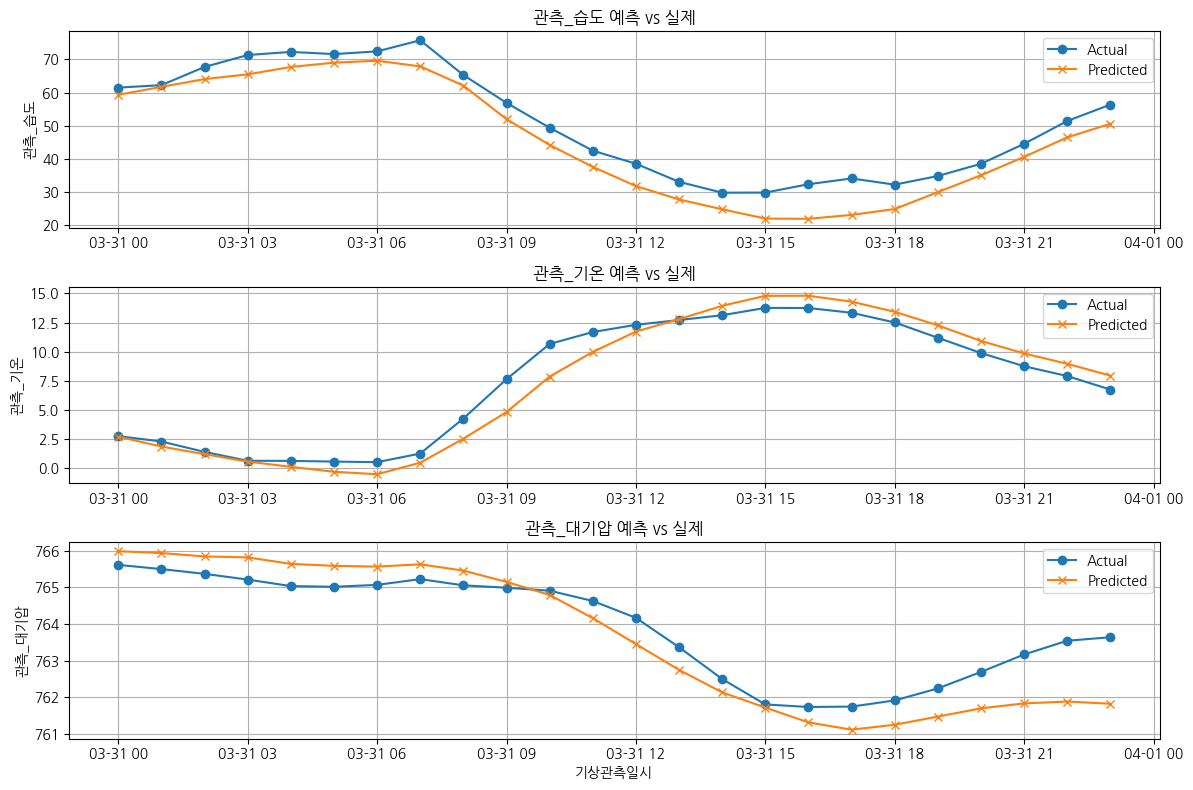

In [105]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 변수 목록
variables = ['관측_습도', '관측_기온', '관측_대기압']

# 변수별 그래프
for i, col in enumerate(variables):
    plt.subplot(3, 1, i + 1)

    # 실제값
    plt.plot(actual_data.index, actual_data[col], label='Actual', marker='o')

    # 예측값
    plt.plot(subset_data.index, subset_data[col], label='Predicted', marker='x')

    plt.title(f'{col} 예측 vs 실제')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)

plt.xlabel('기상관측일시')
plt.tight_layout()
plt.show()